# Product Recognition on Store Shelves

- Baraghini Nicholas
- Marini Luca

### Import of the libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Step A - Multiple Product Detection:

Load first scene image

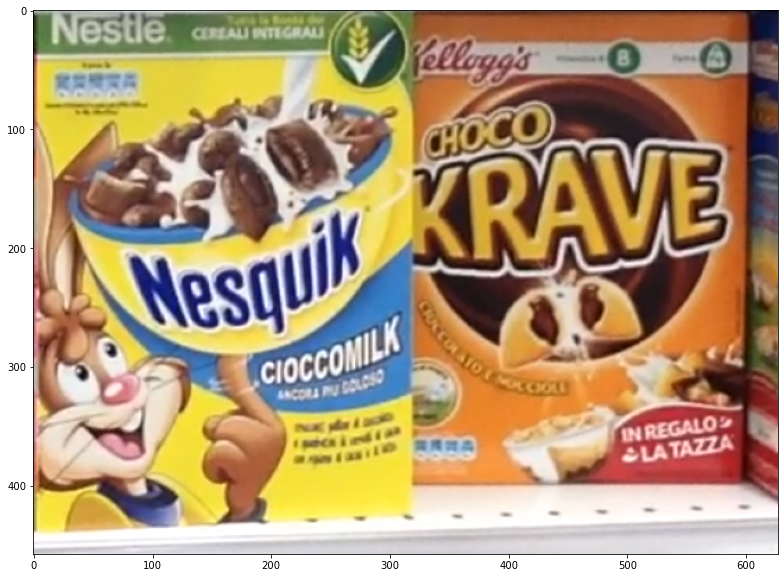

In [2]:
#Load Scene
scene_img = cv2.imread('./scenes/e1.png', cv2.COLOR_BGR2RGB)

#Plot Scene
plt.figure(figsize=(20, 10)) 
plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB));

Load first model image

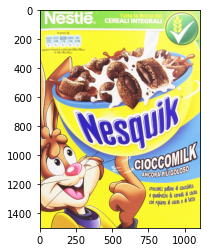

In [3]:
#Load Model
model_img = cv2.imread('./models/0.jpg', cv2.COLOR_BGR2RGB)

#Plot Model
plt.figure() 
plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB));

In [4]:
sift = cv2.xfeatures2d.SIFT_create()

In [5]:
# model_img = cv2.cvtColor(model_img, cv2.COLOR_BGR2GRAY)
kp_model = sift.detect(model_img)

In [6]:
# Number of keypoints 
print(len(kp_model))

# Location of the keypoint
print(kp_model[0].pt)

# Scale
print(kp_model[0].size)

# Rotation
print(kp_model[0].angle)

8044
(3.1264805793762207, 817.734375)
3.059957265853882
175.85983276367188


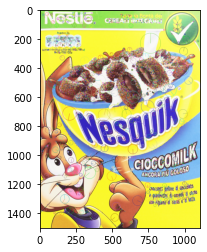

In [7]:
model_img_visualization = cv2.drawKeypoints(model_img, kp_model, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(model_img_visualization, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
# scene_img = cv2.cvtColor(scene_img, cv2.COLOR_BGR2GRAY)
kp_scene = sift.detect(scene_img)

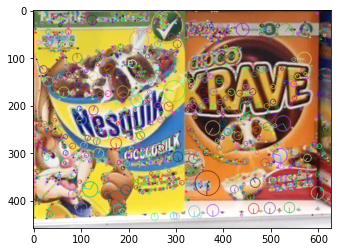

In [9]:
scene_img_visualization = cv2.drawKeypoints(scene_img,kp_scene,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(cv2.cvtColor(scene_img_visualization, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
#Plot Scene
#plt.figure(figsize=(20, 10)) 
#plt.imshow(cv2.cvtColor(scene,cv2.COLOR_BGR2RGB))

In [11]:
kp_model, des_model = sift.compute(model_img, kp_model)
kp_scene, des_scene = sift.compute(scene_img, kp_scene)

In [12]:
print("Number of model descriptors: ", len(des_model))
print("Dimensionality of a SIFT descriptor: ", des_model[0].shape)
print("Type of the descriptor: ", des_model[0].dtype)

Number of model descriptors:  8044
Dimensionality of a SIFT descriptor:  (128,)
Type of the descriptor:  float32


In [13]:
FLANN_INDEX_KDTREE = 1

# Defining parameters for algorithm 
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

# Defining search params.
# checks=50 specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time
search_params = dict(checks = 50)

# Initializing matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching and finding the 2 closest elements for each query descriptor.
matches = flann.knnMatch(des_model, des_scene, k=2)

In [14]:
good = []
for m,n in matches:
    if m.distance < 0.7 * n.distance: #  if m.distance/n.distance < 0.7:
        good.append(m)

In [15]:
# Checking if we found enough matching
MIN_MATCH_COUNT = 10
if len(good)>MIN_MATCH_COUNT:
    
    # building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_model[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Using RANSAC to estimate a robust homography. 
    # It returns the homography M and a mask for the discarded points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Mask of discarded point used in visualization
    matchesMask = mask.ravel().tolist()
    
    # Corners of the query image
    h,w = model_img.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) # myc: these are the 4 corners of the query image
    
    # Projecting the corners into the train image
    dst = cv2.perspectiveTransform(pts,M) # myc: you project the corners by using the homography. M is the homography

    # Drawing the bounding box
    scene_img = cv2.polylines(scene_img, [np.int32(dst)],True, (0, 255, 0), 3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

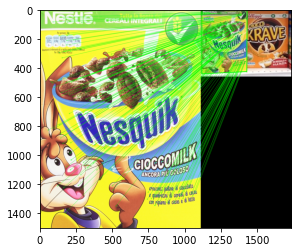

In [16]:
# Drawing the matches
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None, # not draw keypoints only matching lines
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2) # not draw keypoints only lines
img3 = cv2.drawMatches(model_img, kp_model, scene_img, kp_scene, good, None, **draw_params)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

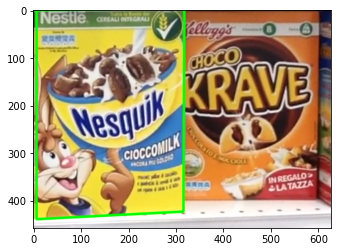

In [17]:
plt.imshow(cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGB))
plt.show()

Creation of some dictionaries that contain all the keypoint, descriptors and images that we will need during stepA, so that they are loaded once and at the beginning, to save later computational cost. We did not create a dictionary also for model images, because we do

In [18]:
NUM_OF_MODELS = 27

# Dictionary that contains all keypoints of model images
kp_model_images = {}
# Dictionary that contains all descriptors of model images
des_model_images = {}

for i in range(NUM_OF_MODELS):
    model_img = cv2.imread('./models/{}.jpg'.format(i), cv2.COLOR_BGR2RGB)
    kp_model = sift.detect(model_img)
    kp_model_images[str(i)], des_model_images[str(i)] = sift.compute(model_img, kp_model)
    # plt.imshow(cv2.cvtColor(model_img, cv2.COLOR_BGR2RGB))
    # plt.show()

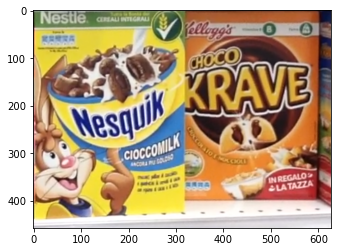

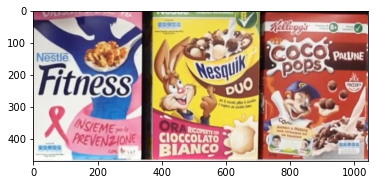

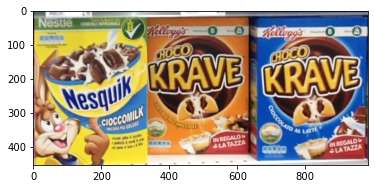

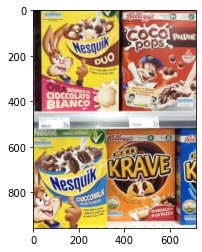

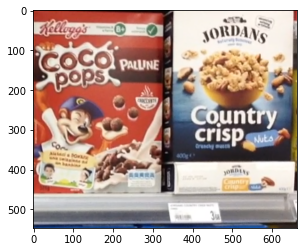

In [19]:
NUM_OF_E_SCENES = 6

# Dictionary that contains all keypoints of easy scene images
kp_e_scenes_images = {}
# Dictionary that contains all descriptors of easy scene images
des_e_scenes_images = {}
# Dictionary that contains all easy scene images
e_scene_images = {}

for i in range(1, NUM_OF_E_SCENES):
    e_scene_images[str(i)] = cv2.imread('./scenes/e{}.png'.format(i), cv2.COLOR_BGR2RGB)
    kp_scene = sift.detect(e_scene_images[str(i)])
    kp_e_scenes_images[str(i)], des_e_scenes_images[str(i)] = sift.compute(e_scene_images[str(i)], kp_scene)
    # scene_img_visualization = cv2.drawKeypoints(scene_img,kp_e_scemes_images['1'],None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(cv2.cvtColor(e_scene_images[str(i)], cv2.COLOR_BGR2RGB))
    plt.show()